In [160]:
from scipy.linalg import expm, sinm, cosm
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import display

In [161]:
from sympy import *
phi, theta, psi, w1, w2, w3, Ix, Iy, Iz, RT, mI, aI, w, mx, my, mz, ax, ay, az = symbols('phi theta psi omega1 omega2 omega3 I_xx I_yy I_zz (R)^T m_I a_I omega m_x m_y m_z a_x a_y a_z')

J = Matrix([w1 + tan(theta)*(w2*sin(phi) + w3*cos(phi)), 
            w2*cos(phi) - w3*sin(phi), 
            sec(theta)*(w2*sin(phi) + w3*cos(phi)),
            ((Iy-Iz)/Ix)*w2*w3,
            ((Iz-Ix)/Iy)*w3*w1,
            ((Ix-Iy)/Iz)*w1*w2,]).jacobian([phi, theta, psi, w1, w2, w3])

print("Jacobian matrix of state transition function f is given below. Although, I am going to assume the first three columns to be 0 taking euler angles to be small" )
display(J)

print("Assuming the euler angles to be small, the transpose of rotation matrix would be:")
RT = Matrix([[1, phi, -theta],
            [phi, 1, -psi],
            [-theta, psi, 1]])

display(RT)
RT = MatrixSymbol("RT", 3, 3)
print("And so, the measurement matrix would be:")
y = Matrix([RT*mI,
            RT*aI,
            w])

display(y)
print("=")

Y = Matrix([mx - phi*my + theta*mz,
           phi*mx + my - psi*mz,
           -theta*mx + psi*my + mz,
           ax - phi*ay + theta*az,
           phi*ax + ay - psi*az,
           -theta*ax + psi*ay + az,
           w1,
           w2,
           w3])
display(Y)

print("Jacobian of this matrix is :")
Y.jacobian([phi, theta, psi, w1, w2, w3])

Jacobian matrix of state transition function f is given below. Although, I am going to assume the first three columns to be 0 taking euler angles to be small


Matrix([
[(omega2*cos(phi) - omega3*sin(phi))*tan(theta),   (omega2*sin(phi) + omega3*cos(phi))*(tan(theta)**2 + 1), 0,                          1,       sin(phi)*tan(theta),        cos(phi)*tan(theta)],
[            -omega2*sin(phi) - omega3*cos(phi),                                                         0, 0,                          0,                  cos(phi),                  -sin(phi)],
[(omega2*cos(phi) - omega3*sin(phi))*sec(theta), (omega2*sin(phi) + omega3*cos(phi))*tan(theta)*sec(theta), 0,                          0,       sin(phi)*sec(theta),        cos(phi)*sec(theta)],
[                                             0,                                                         0, 0,                          0, omega3*(I_yy - I_zz)/I_xx,  omega2*(I_yy - I_zz)/I_xx],
[                                             0,                                                         0, 0, omega3*(-I_xx + I_zz)/I_yy,                         0, omega1*(-I_xx + I_zz)/I_yy],
[               

Assuming the euler angles to be small, the transpose of rotation matrix would be:


Matrix([
[     1, phi, -theta],
[   phi,   1,   -psi],
[-theta, psi,      1]])

And so, the measurement matrix would be:


Matrix([
[m_I*RT],
[a_I*RT],
[ omega]])

=


Matrix([
[ m_x - m_y*phi + m_z*theta],
[   m_x*phi + m_y - m_z*psi],
[-m_x*theta + m_y*psi + m_z],
[ a_x - a_y*phi + a_z*theta],
[   a_x*phi + a_y - a_z*psi],
[-a_x*theta + a_y*psi + a_z],
[                    omega1],
[                    omega2],
[                    omega3]])

Jacobian of this matrix is :


Matrix([
[-m_y,  m_z,    0, 0, 0, 0],
[ m_x,    0, -m_z, 0, 0, 0],
[   0, -m_x,  m_y, 0, 0, 0],
[-a_y,  a_z,    0, 0, 0, 0],
[ a_x,    0, -a_z, 0, 0, 0],
[   0, -a_x,  a_y, 0, 0, 0],
[   0,    0,    0, 1, 0, 0],
[   0,    0,    0, 0, 1, 0],
[   0,    0,    0, 0, 0, 1]])

In [162]:
class KalmanFilter(object):
    
    def __init__(self, DT, SIGMA_M, SIGMA_SD, m_A, m_B, v_U, v_X_0, mx, my, mz, ax, ay, az, M1, M2, M3):
 
        self.DT = DT
        self.mx = mx
        self.my = my
        self.mz = mz
        self.ax = ax
        self.ay = ay
        self.az = az
        self.M1 = M1
        self.M2 = M2
        self.M3 = M3
        self.m_A = m_A
        self.m_B = m_B
        self.v_U = v_U
        self.m_G = np.matrix([[1, 0, 0, 0, 0, 0],
                              [0, 1, 0, 0, 0, 0],
                              [0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 1]])
        
        self.m_Q = SIGMA_SD*np.matrix([[1, 0, 0, 0, 0, 0],
                              [0, 1, 0, 0, 0, 0],
                              [0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 1]])
        
        self.m_I = np.matrix([[1, 0, 0, 0, 0, 0],            
                            [0, 1, 0, 0, 0, 0],
                            [0, 0, 1, 0, 0, 0],            
                            [0, 0, 0, 1, 0, 0],
                            [0, 0, 0, 0, 1, 0],            
                            [0, 0, 0, 0, 0, 1]])

        #self.m_H = np.matrix([[1, 0]])
        self.m_R = (SIGMA_M**2) * np.matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 1, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 1, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 1, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 1]])    
        
        #initial state and error
        self.v_X = v_X_0
        self.m_P = 0.1*np.matrix([[1, 0, 0, 0, 0, 0],
                                  [0, 1, 0, 0, 0, 0],
                                  [0, 0, 1, 0, 0, 0],
                                  [0, 0, 0, 1, 0, 0],
                                  [0, 0, 0, 0, 1, 0],
                                  [0, 0, 0, 0, 0, 1]])
       
        self.zeroc = np.zeros([6, 12])
        self.zero6 = np.zeros([6, 6])
        self.Ih = np.concatenate((self.m_I, self.zero6), axis=1)
        self.Il = np.concatenate((self.zero6, self.m_I), axis=0)
        
    def kf_propogate(self):
        
        Ix = 0.01
        Iy = 0.01
        Iz = 0.02
        self.m_A = np.matrix([[0, 0, 0, 1, math.sin(self.v_X[0,0])*math.tan(self.v_X[1,0]), math.cos(self.v_X[0,0])*math.tan(self.v_X[1,0])],
                              [0, 0, 0, 0, math.cos(self.v_X[0,0]), -1*math.sin(self.v_X[0,0])],
                              [0, 0, 0, 0, math.sin(self.v_X[0,0])/math.cos(self.v_X[1,0]), math.cos(self.v_X[0,0])/math.cos(self.v_X[1,0])],
                              [0, 0, 0, 0, self.v_X[5,0]*(Iy - Iz)/Ix, self.v_X[4,0]*(Iy - Iz)/Ix],
                              [0, 0, 0, self.v_X[5,0]*(Iz - Ix)/Iy, 0, self.v_X[3,0]*(Iz - Ix)/Iy],
                              [0, 0, 0, self.v_X[4,0]*(Ix - Iy)/Iz, self.v_X[3,0]*(Ix - Iy)/Iz, 0]])       
        #self.m_A = np.matrix([[0, 0, 0, 1, math.sin(self.v_X[0,0])*math.tan(self.v_X[1,0]), math.cos(self.v_X[0,0])*math.tan(self.v_X[1,0])],
        #                      [0, 0, 0, 0, math.cos(self.v_X[0,0]), -1*math.sin(self.v_X[0,0])],
        #                      [0, 0, 0, 0, math.sin(self.v_X[0,0])/math.cos(self.v_X[1,0]), math.cos(self.v_X[0,0])/math.cos(self.v_X[1,0])],
        #                      [0, 0, 0, 0, self.v_X[5,0]*(Iy - Iz)/Ix, 0],
        #                      [0, 0, 0, self.v_X[5,0]*(Iz - Ix)/Iy, 0, 0],
        #                      [0, 0, 0, 0, self.v_X[3,0]*(Ix - Iy)/Iz, 0]])       
        
        
        
        #discretizing continuous time system to X(n+1) = phi*X(n) + tau*U(n)
        
        #phi = e^(A*dt)
        self.m_phi = expm(self.DT*self.m_A)

        #tau = (phi - I)(A^-1)B, if A is singular, we apply a different formula
        if np.linalg.det(self.m_A) == 0:
            A_bar = np.concatenate((np.concatenate((self.m_A,self.m_B), axis=1),self.zeroc), axis=0)
            exp_A_bar = expm(self.DT*A_bar)
            self.m_tau = self.Ih*exp_A_bar*self.Il
        else:
            self.m_tau = (self.m_phi - self.m_I)*(np.linalg.inv(self.m_A))*self.m_B
        
        #prediciting state and covariance of error in state from model parameters
        self.v_X = np.dot(self.m_phi, self.v_X) + np.dot(self.m_tau, self.v_U)
        self.m_P = np.dot(np.dot(self.m_phi, self.m_P), self.m_phi.T) + self.DT*np.dot(np.dot(self.m_G, self.m_Q), self.m_G.T)
        
        return self.v_X
    
    def kf_update(self, v_y_m, mx, my, mz, ax, ay, az):
        
        self.m_H = np.matrix([[-my, mz, 0, 0, 0, 0],
                              [mx, 0, -mz, 0, 0, 0],
                              [0, -mx, my, 0, 0, 0],
                              [-ay, az, 0, 0, 0, 0],
                              [ax, 0, -az, 0, 0, 0],
                              [0, -ax, ay, 0, 0, 0],
                              [0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 1]])
        #predicted output
        v_yp = np.matrix([[mx - self.v_X[0,0]*my + self.v_X[1,0]*mz],
                          [self.v_X[0,0]*mx + my - self.v_X[2,0]*mz],
                          [-1*self.v_X[1,0]*mx + self.v_X[2,0]*my + mz],
                          [ax - self.v_X[0,0]*ay + self.v_X[1,0]*az],
                          [self.v_X[0,0]*ax + ay - self.v_X[2,0]*az],
                          [-1*self.v_X[1,0]*ax + self.v_X[2,0]*ay + az],
                          [self.v_X[3,0]],
                          [self.v_X[4,0]],
                          [self.v_X[5,0]]])
        
        #S = CPC^T + R
        m_S = np.dot(self.m_H, np.dot(self.m_P, self.m_H.T)) + self.m_R

        #updating Kalman Gain
        m_K = np.dot(np.dot(self.m_P, self.m_H.T), np.linalg.inv(m_S))
        
        #updating state
        self.v_X = self.v_X + np.dot(m_K, (v_y_m - v_yp))
        
        #updating error
        I = np.eye(self.m_H.shape[1])
        self.m_P = (I - (m_K * self.m_H)) * self.m_P
        
    def real_ode(self, v_X, r_t):

        Ix = 0.01
        Iy = 0.01
        Iz = 0.02

        
        v_dx1dt_st = v_X[3] + math.tan(v_X[1])*(v_X[4]*math.sin(v_X[0]) + v_X[5]*math.cos(v_X[0]))
        v_dx2dt_st = v_X[4]*math.cos(v_X[0]) - v_X[5]*math.sin(v_X[0])
        v_dx3dt_st = (v_X[4]*math.sin(v_X[0]) + v_X[5]*math.cos(v_X[0]))/math.cos(v_X[1])
        v_dx4dt_st = v_X[4]*v_X[5]*(Iy - Iz)/Ix + self.M1
        v_dx5dt_st = v_X[5]*v_X[3]*(Iz - Ix)/Iy + self.M2
        v_dx6dt_st = v_X[3]*v_X[4]*(Ix - Iy)/Iz + self.M3
        
        return [v_dx1dt_st, v_dx2dt_st, v_dx3dt_st, v_dx4dt_st, v_dx5dt_st, v_dx6dt_st]

        

In [165]:
def main():
       
    '''
    This code is written for a system with six states, three measurements and three control inputs.
    '''
 
    #inputs
    '''THE FOLLOWING PARAMETER VALUES HAVE BEEN TAKEN RANDOMLY'''
    mx=1
    my=0
    mz=-1
    ax=1
    ay=0
    az=-1
    #these are the control inputs (torque applied)
    M1 = -1
    M2 = 1
    M3 = 0.01
    #simulation parameters
    T = 20
    DT = 0.1
    r_t = np.arange(0, T, DT)
    
    #standard deviation in measurement errors
    SIGMA_M = 0.01
        
    #standard deviation of state disturbances Q
    SIGMA_SD = 0.01

    #dX/dt = AX + BU + Q
    m_A = np.matrix([[0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]]) 
    
    m_B = np.matrix([[1, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 1]])
    
    v_U = np.matrix([[0],
                     [0],
                     [0],
                     [M1],
                     [M2],
                     [M3]])
    
    #initial state
    v_X_0 = np.matrix([[0],
                       [0],
                       [0],
                       [0],
                       [0],
                       [0]])
     
    #creating Kalman Filter object
    kf = KalmanFilter(DT, SIGMA_M, SIGMA_SD, m_A, m_B, v_U, v_X_0, mx, my, mz, ax, ay, az, M1, M2, M3)
    m_predictions_st = []
    m_measurements_m = [[0],
                        [0],
                        [0],
                        [0],
                        [0],
                        [0],
                        [0],
                        [0],
                        [0]]
    m_measurements_p = [[0],
                        [0],
                        [0],
                        [0],
                        [0],
                        [0],
                        [0],
                        [0],
                        [0]]
    
    #solving DE to get model track
    m_real_track_st = np.matrix(odeint(kf.real_ode, np.squeeze(np.array(v_X_0)).tolist(), r_t))
   

    for state in m_real_track_st:
        #Generating mesurement
        state = state.T
        v_y_m = np.matrix([[mx - state[0,0]*my + state[1,0]*mz      + np.random.normal(0, SIGMA_M)],
                           [state[0,0]*mx + my - state[2,0]*mz      + np.random.normal(0, SIGMA_M)],
                           [-1*state[1,0]*mx + state[2,0]*my + mz   + np.random.normal(0, SIGMA_M)],
                           [ax - state[0,0]*ay + state[1,0]*az      + np.random.normal(0, SIGMA_M)],
                           [state[0,0]*ax + ay - state[2,0]*az      + np.random.normal(0, SIGMA_M)],
                           [-1*state[1,0]*ax + state[2,0]*ay + az   + np.random.normal(0, SIGMA_M)],
                           [state[3,0]                              + np.random.normal(0, SIGMA_M)],
                           [state[4,0]                              + np.random.normal(0, SIGMA_M)],
                           [state[5,0]                              + np.random.normal(0, SIGMA_M)]]) 
        
        m_measurements_m = np.append(m_measurements_m, v_y_m, axis = 1)
        #Kalman Filter application
        kf.kf_propogate()       
        m_predictions_st.append(kf.v_X)
        
        v_y_p = np.matrix([[mx - kf.v_X[0,0]*my + kf.v_X[1,0]*mz],
                           [kf.v_X[0,0]*mx + my - kf.v_X[2,0]*mz],
                           [-1*kf.v_X[1,0]*mx + kf.v_X[2,0]*my + mz],
                           [ax - kf.v_X[0,0]*ay + kf.v_X[1,0]*az],
                           [kf.v_X[0,0]*ax + ay - kf.v_X[2,0]*az],
                           [-1*kf.v_X[1,0]*ax + kf.v_X[2,0]*ay + az],
                           [kf.v_X[3,0]],
                           [kf.v_X[4,0]],
                           [kf.v_X[5,0]]]) 
        #print(state[1,0])
        m_measurements_p = np.append(m_measurements_p, v_y_p, axis = 1)
        kf.kf_update(v_y_m, mx, my, mz, ax, ay, az)

    
    m_measurements_m = np.delete(m_measurements_m, 0, 1)
    m_measurements_p = np.delete(m_measurements_p, 0, 1)
    v_measures_m = np.array(m_measurements_m)[0]
    v_predict_measures_p = np.array(m_measurements_p)[0]
    v_states_kalman_st = np.array(m_predictions_st).T
     
    #plotting results
    
    fig1 = plt.figure()
    #fig1.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    #plt.plot(r_t, v_positions_m, label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, np.array(m_real_track_st)[:,0], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_states_kalman_st[0][0], label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('phi', fontsize=10)
    plt.legend()
    
    fig2 = plt.figure()
    #fig2.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    #plt.plot(r_t, v_velocities_m, label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, np.array(m_real_track_st)[:,1], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_states_kalman_st[0][1], label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('theta', fontsize=10)
    plt.legend()
    
    fig3 = plt.figure()
    #fig3.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    #plt.plot(r_t, v_velocities_m, label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, np.array(m_real_track_st)[:,2], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_states_kalman_st[0][2], label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('psi', fontsize=10)
    plt.legend()
    
    fig4 = plt.figure()
    #fig4.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    #plt.plot(r_t, v_velocities_m, label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, np.array(m_real_track_st)[:,3], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_states_kalman_st[0][3], label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('w1', fontsize=10)
    plt.legend()
    
    fig5 = plt.figure()
    #fig5.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    #plt.plot(r_t, v_velocities_m, label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, np.array(m_real_track_st)[:,4], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_states_kalman_st[0][4], label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('w2', fontsize=10)
    plt.legend()
    
    fig6 = plt.figure()
    #fig6.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    #plt.plot(r_t, v_velocities_m, label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, np.array(m_real_track_st)[:,5], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_states_kalman_st[0][5], label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('w3', fontsize=10)
    plt.legend()
    
    '''fig3 = plt.figure()
    fig3.suptitle('Measurement difference', fontsize=20)
    #plt.plot(r_t, v_velocities_m, label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, v_positions_m - v_positions_kalman_st, label='Real Track', color='black', linewidth=0.5)
    #plt.plot(r_t, v_velocities_kalman_st, label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Measurement difference', fontsize=10)
    plt.legend()
    
    fig4 = plt.figure()
    fig4.suptitle('Velocity Errors', fontsize=20)
    #plt.plot(r_t, v_velocities_m, label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, np.array(m_real_track_st)[:,0] - v_positions_kalman_st, label='Real Track', color='black', linewidth=0.5)
    #plt.plot(r_t, v_velocities_kalman_st, label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Velocity errors (m/s)', fontsize=10)
    plt.legend()'''
    
    plt.show()

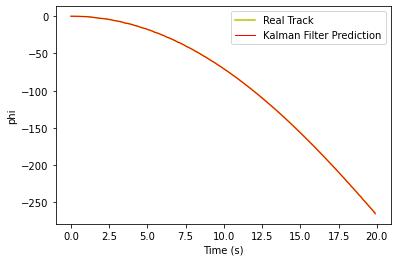

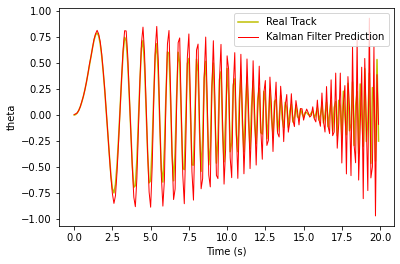

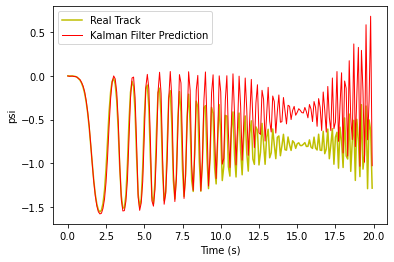

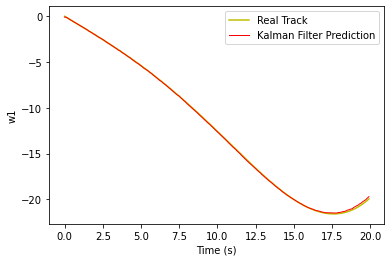

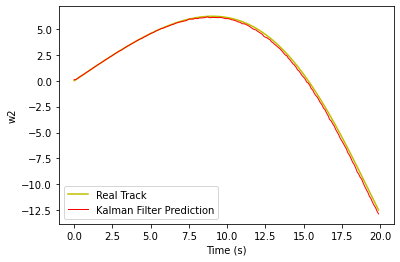

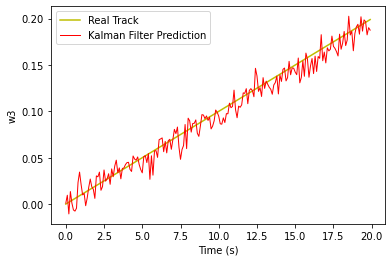

In [166]:
if __name__ == '__main__':
    main()